In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix

In [2]:
def gmm(k, x):
    '''
    Implementation of the Gaussian Mixture Model using E and M steps
    
    Args:
        k: number of Gaussians to fit
        x: input data

    Returns:
        Mean, covariance, and weights for each Gaussian model
    '''
    
    def log_likelihood(mu, cov, w):
        '''
        Computes the log likelihood of x given Gaussian parameters
        
        Args:
            mu: list of means for each component
            cov: list of covariances for each component
            w: list of weights for each component    
            
        Returns:
            Log likelihood value
        '''
        # probability density function
        prob = np.array([multivariate_normal.pdf(x=x, mean=mu[j], cov=cov[j]) for j in range(k)])
        # weighted probabilities
        wt_prob = np.array([w[j] * prob[j] for j in range(k)])

        return np.log(wt_prob.sum(axis=1)).sum()

    def e_step(mu, cov, w):
        '''
        Expectation step: computes expectation of likelihood values given current Gaussian parameters
        
        Args:
            mu: list of means for each component
            cov: list of covariances for each component
            w: list of weights for each component    
            
        Returns:
            Expectation of likelihood values        
        '''
        # probability densities for each Gaussian component
        prob = np.array([multivariate_normal.pdf(x=x, mean=mu[j], cov=cov[j]) for j in range(k)])
        # weighted probabilities
        wt_prob = np.array([w[j] * prob[j] for j in range(k)])

        # sum weighted probabilities
        sum_wt_prob = wt_prob.sum(axis=0)
        
        # compute expectation of weighted probability values 
        pi = np.array([wt_prob[j]/sum_wt_prob for j in range(k)]).transpose()

        return pi

    def m_step(pi, n):
        '''
        Maximization step: update model parameters given expectation values
        
        Args:
            pi: expectation values for samples in dataset
            
        Returns:
            Updated parameters for each component
        '''
        # sum of expectation
        sum_pi = np.sum(pi, axis=0)

        # initialize parameter lists
        mu, cov, w = [], [], []

        for j in range(k):
            # updated mean is sum of product between data and expectation values 
            # divided by expectation sum for each sample
            mu.append(np.sum((x.transpose() * pi[:, j]).transpose(), axis=0)/sum_pi[j])
            
            # updated covariance is weighted difference between data and current mean
            # dot product with same difference and divided by sum of expectations
            cov.append((1/sum_pi[j])*np.dot(((x-mu[j]).transpose() * pi[:, j]),(x-mu[j])))

            # updated weight is sum of expectations divided by number of samples
            w.append(pi[:,j].sum()/n)

        mu, cov, w = np.array(mu), np.array(cov), np.array(w)
        return mu, cov, w

    n = x.shape[0] # number of samples

    d = x.shape[1] # number of dimensions in dataset

    # initializing parameters
    mu = np.random.choice(x.flatten(), size=(k, d), replace=False)  # means are random at initialization

    cov = []
    for i in range(k):
        # initialize covariance matrix to a symmetric postive-definite one
        cov.append(make_spd_matrix(d))
        
    cov = np.array(cov)
    
    w = np.ones(k)/k  # weights are evenly distributed at intialization
    
    llh = log_likelihood(mu, cov, w)  # compute log likelihood of x with starting params

    # do first EM steps outside of while loop
    pi = e_step(mu, cov, w)
    mu, cov, w = m_step(pi, n)
    llh_new = log_likelihood(mu, cov, w)
    
    # until log likelihood converges
    while llh != llh_new:
        llh = llh_new
        
        # do EM stps
        pi = e_step(mu, cov, w)
        mu, cov, w = m_step(pi, n)
        
        # calculate new log likelihood
        llh_new = log_likelihood(mu, cov, w)

    return mu, cov, w

In [3]:
# The following code is adapted from an example on sklearn to visualize Gaussian ellipsoids:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html

import itertools
from scipy import linalg
import matplotlib as mpl

color_iter = itertools.cycle(["gold", "lavender", "green", "c"])

def plot_gmm(X, mu, cov):
    '''
    Plot data as scatter plot and Gaussian components as ellipsoids
    '''
    fig, ax = plt.subplots()

    ax.scatter(X[:,0], X[:,1], s=5)
    for i, (mean, covar, color) in enumerate(zip(mu, cov, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)


    plt.xticks(())
    plt.yticks(())

    plt.show()
    return

In [4]:
# Testing GMM implementation on datasets

two_txt = "2gaussian.txt"  # contains 2 Gaussian components
three_txt = "3gaussian.txt"  # contains 3 Gaussian components

two_gauss = np.loadtxt(two_txt)
three_gauss = np.loadtxt(three_txt)

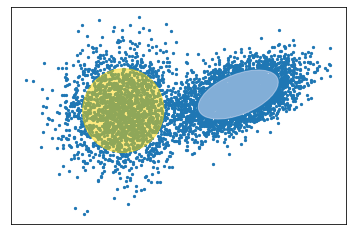

In [5]:
mu, cov, w  = gmm(2, two_gauss)
plot_gmm(two_gauss, mu, cov)

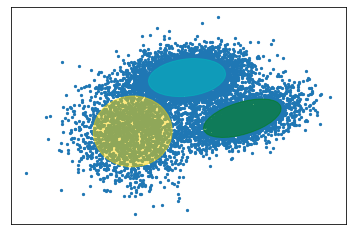

In [6]:
mu, cov, w  = gmm(3, three_gauss)
plot_gmm(three_gauss, mu, cov)